In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sympy.printing.pretty.pretty_symbology import line_width

from nds_toolbox.preprocessing.features import compute_wavelet

import seaborn as sns



FIG_WIDTH = 7.5
MY_FONT_SIZE = 9


plt.rcParams.update({
    # --- Fonts ---
    "font.family": "Arial",
    "font.size": MY_FONT_SIZE,

    # --- Legend ---
    "legend.fontsize": MY_FONT_SIZE,
    "legend.frameon": False,

    # --- Titles ---
    "figure.titlesize": MY_FONT_SIZE,
    "axes.titleweight": "normal",
    "axes.titlesize": MY_FONT_SIZE,

    # --- Axes ---
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.unicode_minus": True,
    "axes.labelsize": MY_FONT_SIZE,

    # --- Lines & markers ---
    "lines.linewidth": 1.0,
    "lines.markersize": 0.7,

    # --- Ticks ---
    "xtick.labelsize": MY_FONT_SIZE,
    "ytick.labelsize": MY_FONT_SIZE,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "axes.linewidth": 0.7,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,

    # Grid
    "axes.grid": False,
    "grid.linestyle": ":",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,


    # --- Layout ---
    "figure.autolayout": True,

    # --- DPI ---
    "savefig.dpi": 900,
    "figure.dpi": 200,
})


# Load the data and model result

In [2]:

signal_dir = "../data/CTF_rest"
files = [f"{signal_dir}/bursts/subject{i:02d}.npy" for i in range(65)]
data_all = [np.load(f, allow_pickle=True) for f in files]


fs = 100
seed = 2025

[ 3 11 22 34 42 63]
[ 5.5 11.  17.  21.  31.5]


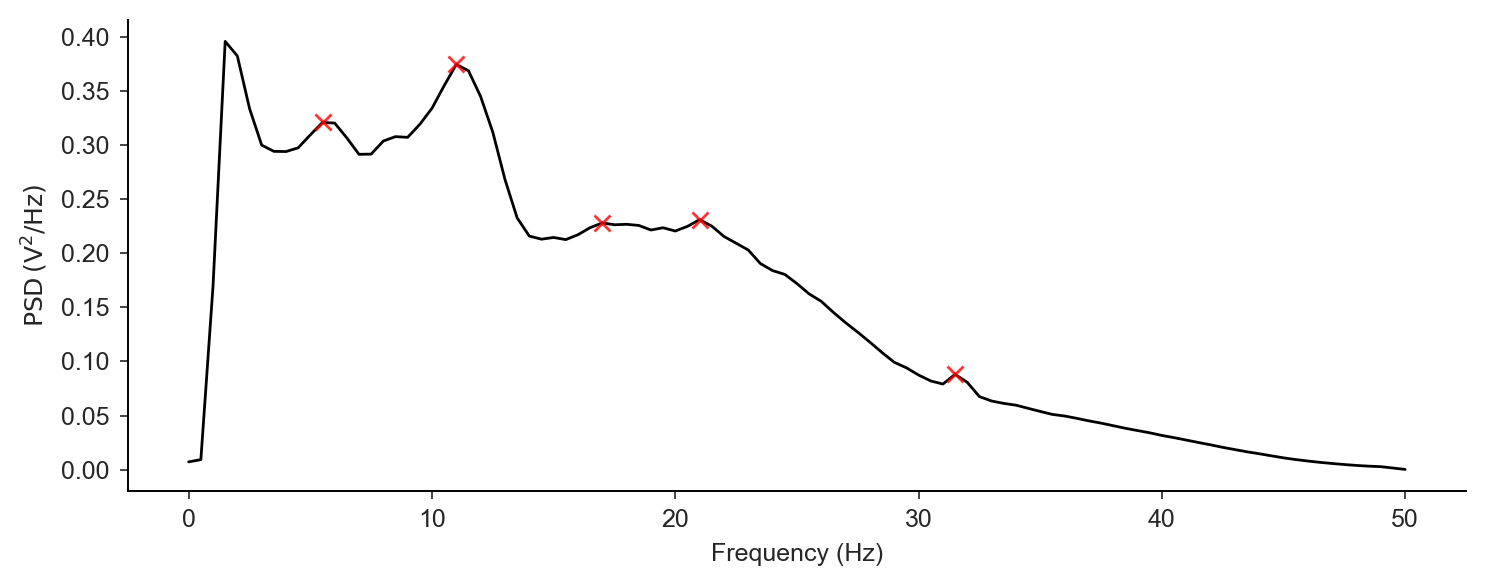

In [3]:
from scipy.signal import welch
import matplotlib.pyplot as plt
psd_sample = []
for data in data_all:
    f, psd = welch(data.T, fs, scaling="density", average="mean",nperseg=fs * 2)
    psd_sample.append(psd)

psd_sample = np.array(psd_sample)  # (65, 1, 51)
mean_psd = np.mean(psd_sample, axis=0)[0]

from scipy.signal import find_peaks
distance_bins = int(4/(f[1] - f[0]))
peaks, _ = find_peaks(mean_psd, distance= distance_bins)

print(peaks)
peaks = peaks[1:] #manually remove 2 hz
print(f[peaks])


fig = plt.figure(figsize=(FIG_WIDTH, 3))
plt.plot(f, mean_psd, "k")
plt.plot(f[peaks], mean_psd[peaks], "rx", ms = 6, alpha = 0.8)

plt.xlabel(r"Frequency (Hz)")
plt.ylabel(r"$\mathrm{PSD}\,(\mathrm{V}^2/\mathrm{Hz})$")


fig.savefig(
    f"../figures/CTF_rest_spectrum_peaks.jpg",
    bbox_inches="tight")




plt.show()

In [4]:
signal = np.concatenate(data_all)
signal = (signal - np.mean(signal)) / np.std(signal) #standarize the signal
signal = signal[:, 0]


from nds_toolbox.preprocessing.features import choose_embedding_dim

num_emb = choose_embedding_dim(np.mean(f[peaks]), fs, min_cycles = 2.5, ensure_odd = True)

print("num_embeddings", num_emb) #15 emb







#alpha will be bayesian estimated, but to roughly estimate num_states beforehand, i set it to 1 (uniform stickbreaking beta distribution)
num_states = int(np.ceil(np.log(len(signal)))) # E[K] = a ln n
print("num_states: ", num_states)
# this sets K above the expected occupied clusters
#15 states




Chosen window size = 0.145 (sec): minimum cycles of 2.5 at 17.2 Hz
Chosen embedding dimension = 15: sampling rate = 100 Hz
num_embeddings 15
num_states:  15


In [5]:
2/f[peaks]

array([0.36363636, 0.18181818, 0.11764706, 0.0952381 , 0.06349206])

In [6]:
print(f[peaks])
np.round(((2/40)*250))

[ 5.5 11.  17.  21.  31.5]


np.float64(12.0)

In [7]:
from nds_toolbox.preprocessing.features import (compute_tde,trim_data)
tde_signal = compute_tde(signal, num_emb)



trimmed_signal = trim_data(signal, num_embeddings = num_emb, verbose = False)
trimmed_time_vec = np.linspace(0, len(trimmed_signal)/fs, len(trimmed_signal))

7 data points were lost from both ends.
data shape: (1929818, 15)


## load the model result

In [8]:
import pickle
performance_dir = "../data/CTF_rest"
load_path = os.path.join(performance_dir, "CTF_rest_result.pkl")

with open(load_path, "rb") as f:
    res = pickle.load(f)



In [9]:
df = pd.DataFrame(res)
df.head()

,method,signal,true_states,burst_f,fs,snr,est_params,loss_best,model_id_best,seed_best,...,fit_t,pred_t,total_time,num_states,num_emb,est_states,order,summary_stats,mcc,loss
0,DP-GMM,"[-0.7449765, 0.003586299, 0.553737, 0.00757364...",None,None,100,None,"{'alpha': 0.71032727, 'weights': [0.237125, 0....",1.1638087,5,2673126337,...,480.048446,6.172416,486.220862,15,15,"[1, 2, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 0, 1, 3, 5, 6, 4, 7, 10, 9, 8, 11, 12, 14,...",{'fractional_occupancies': [0.3244663486401308...,None,1.1638087
1,DP-GMM (Imputed),"[-0.7449765, 0.003586299, 0.553737, 0.00757364...",None,None,100,None,"{'alpha': 0.71032727, 'weights': [0.237125, 0....",1.1638087,5,2673126337,...,480.048446,6.172416,486.220862,15,15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 0, 1, 3, 5, 6, 4, 7, 10, 9, 8, 11, 12, 14,...",{'fractional_occupancies': [0.3819759168999356...,None,1.1638087


In [10]:
df.query("method == 'DP-GMM'").est_params.values[0].keys()

dict_keys(['alpha', 'weights', 'means', 'covs', 'untrunc_means', 'untrunc_covs', 'untrunc_weights', 'trunc_info'])

In [11]:

df.query("method == 'DP-GMM'").est_params.values[0].keys()

dict_keys(['alpha', 'weights', 'means', 'covs', 'untrunc_means', 'untrunc_covs', 'untrunc_weights', 'trunc_info'])

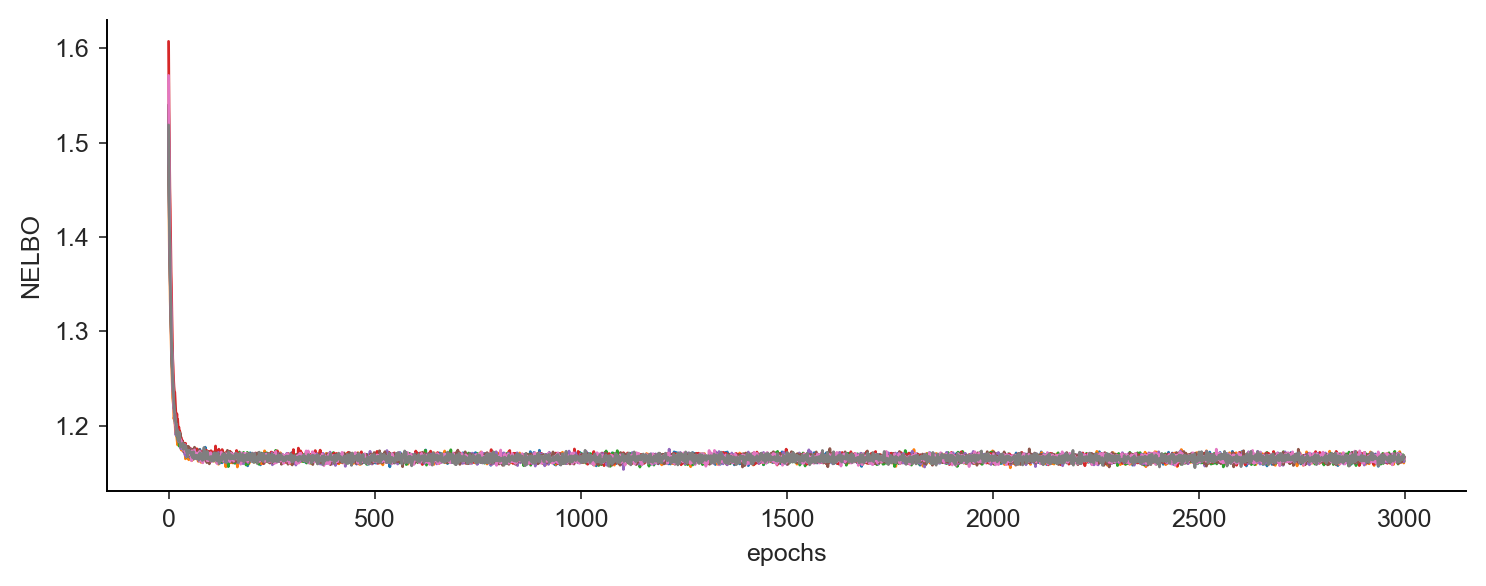

In [12]:
loss_all = df.query("method == 'DP-GMM'").loss_all.values[0]

fig = plt.figure(figsize=(FIG_WIDTH, 3))
for loss in loss_all:
    plt.plot(loss)
    plt.xlabel("epochs")
    plt.ylabel("NELBO")
plt.show()

In [256]:
np.sum(untrunc_weights[:7])

Array(0.99659103, dtype=float32)

In [13]:
#tde-dpgmm
est_states = df.query("method == 'DP-GMM'").est_states.to_numpy()[0]
alpha, weights, means, covs, untrunc_means, untrunc_covs, untrunc_weights, trunc_info= df.query("method == 'DP-GMM'").est_params.values[0].values()



est_states_onehot = np.eye(num_states)[est_states]



#tde-dpgmm (constrained)

est_states = df.query("method == 'DP-GMM (Imputed)'").est_states.to_numpy()[0]
est_states_onehot = np.eye(num_states)[est_states]
f, psds = df.query("method == 'DP-GMM (Imputed)'").summary_stats.values[0]["spectra"]
fo = df.query("method == 'DP-GMM (Imputed)'").summary_stats.values[0]["fractional_occupancies"]

summary_stats = df.query("method == 'DP-GMM (Imputed)'").summary_stats.values[0]
fo = summary_stats["fractional_occupancies"]
lifetimes = summary_stats["lifetimes"]
median_lifetimes = summary_stats["median_lt_states"]
CV_intervals = summary_stats["CV_intervals"]
burst_rates = summary_stats["burst_rates"]
powers = summary_stats["powers"]
spectra = summary_stats["spectra"]
f_vec, psd_vec = summary_stats["spectra"]


effective_num_states = est_states.max()+1

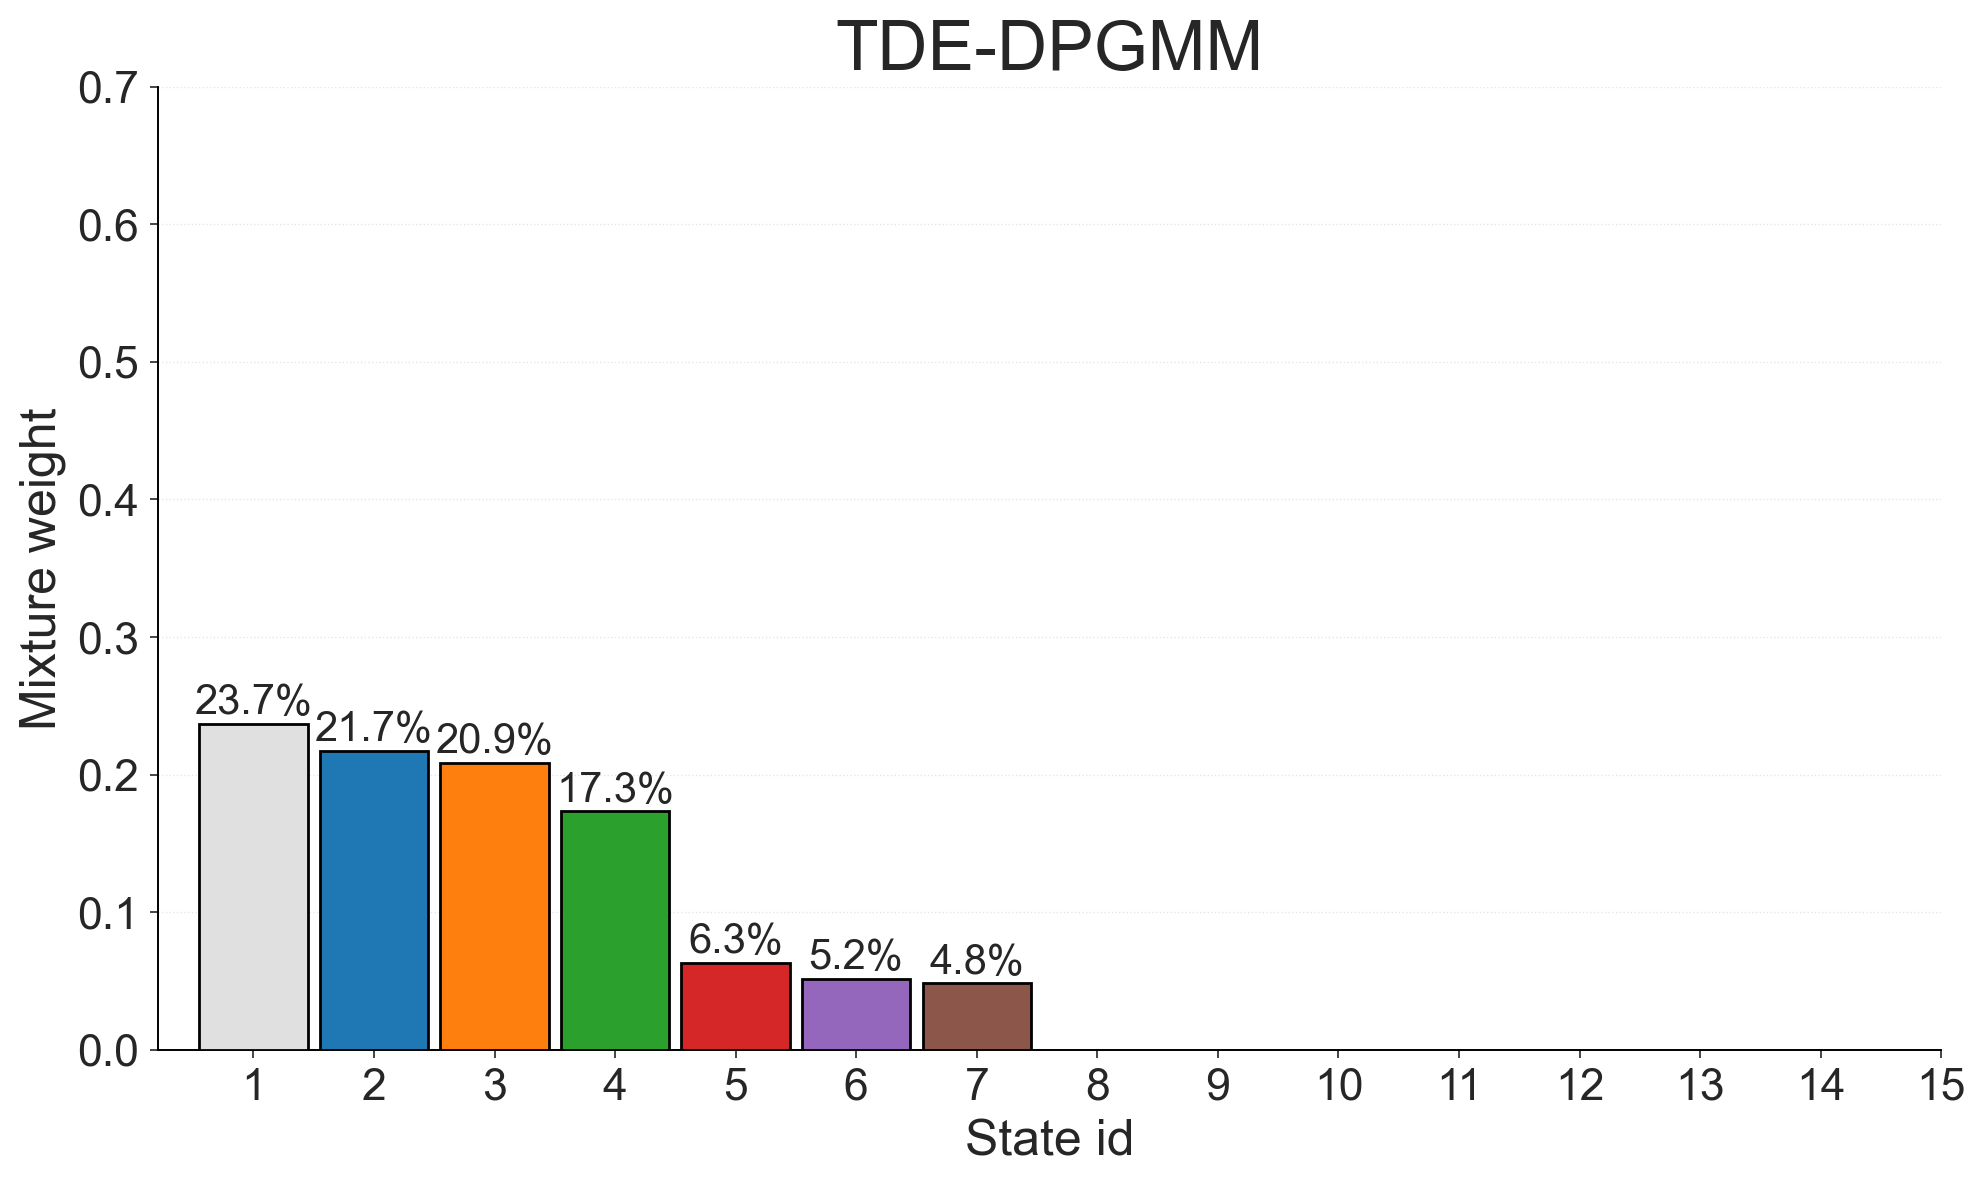

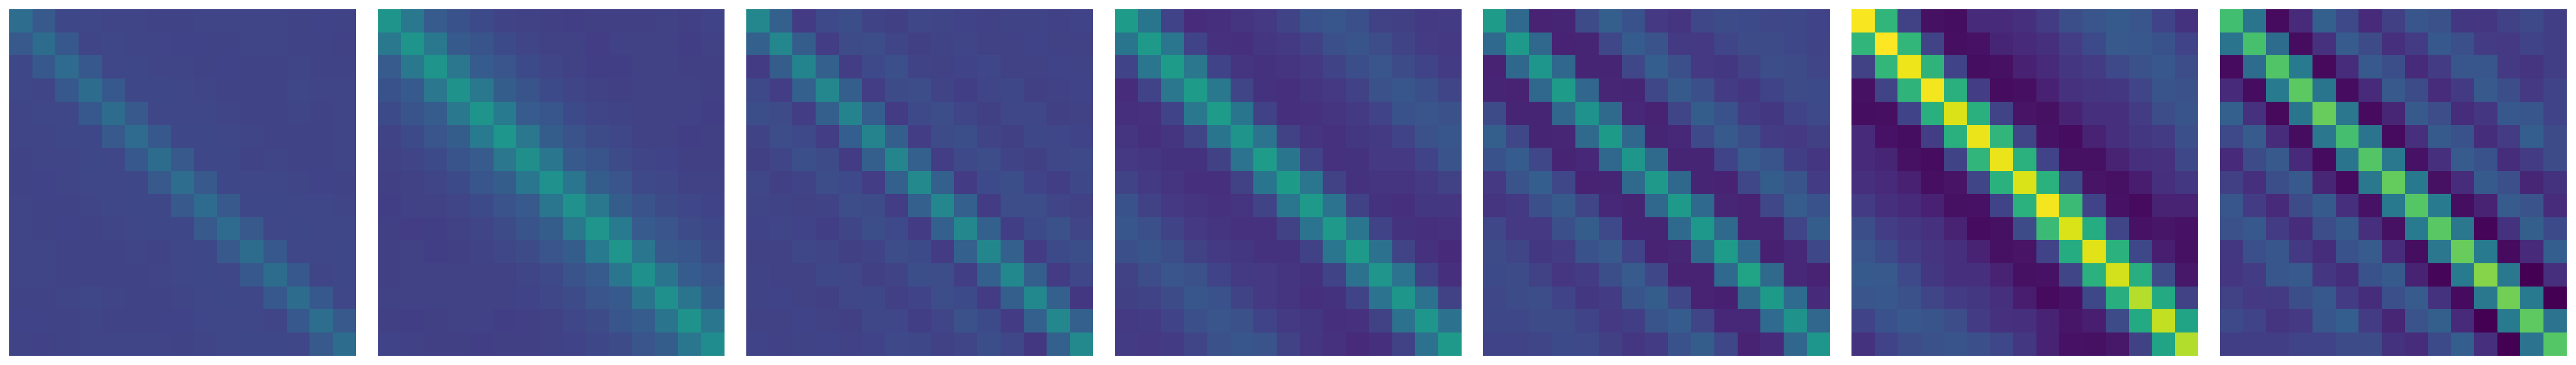

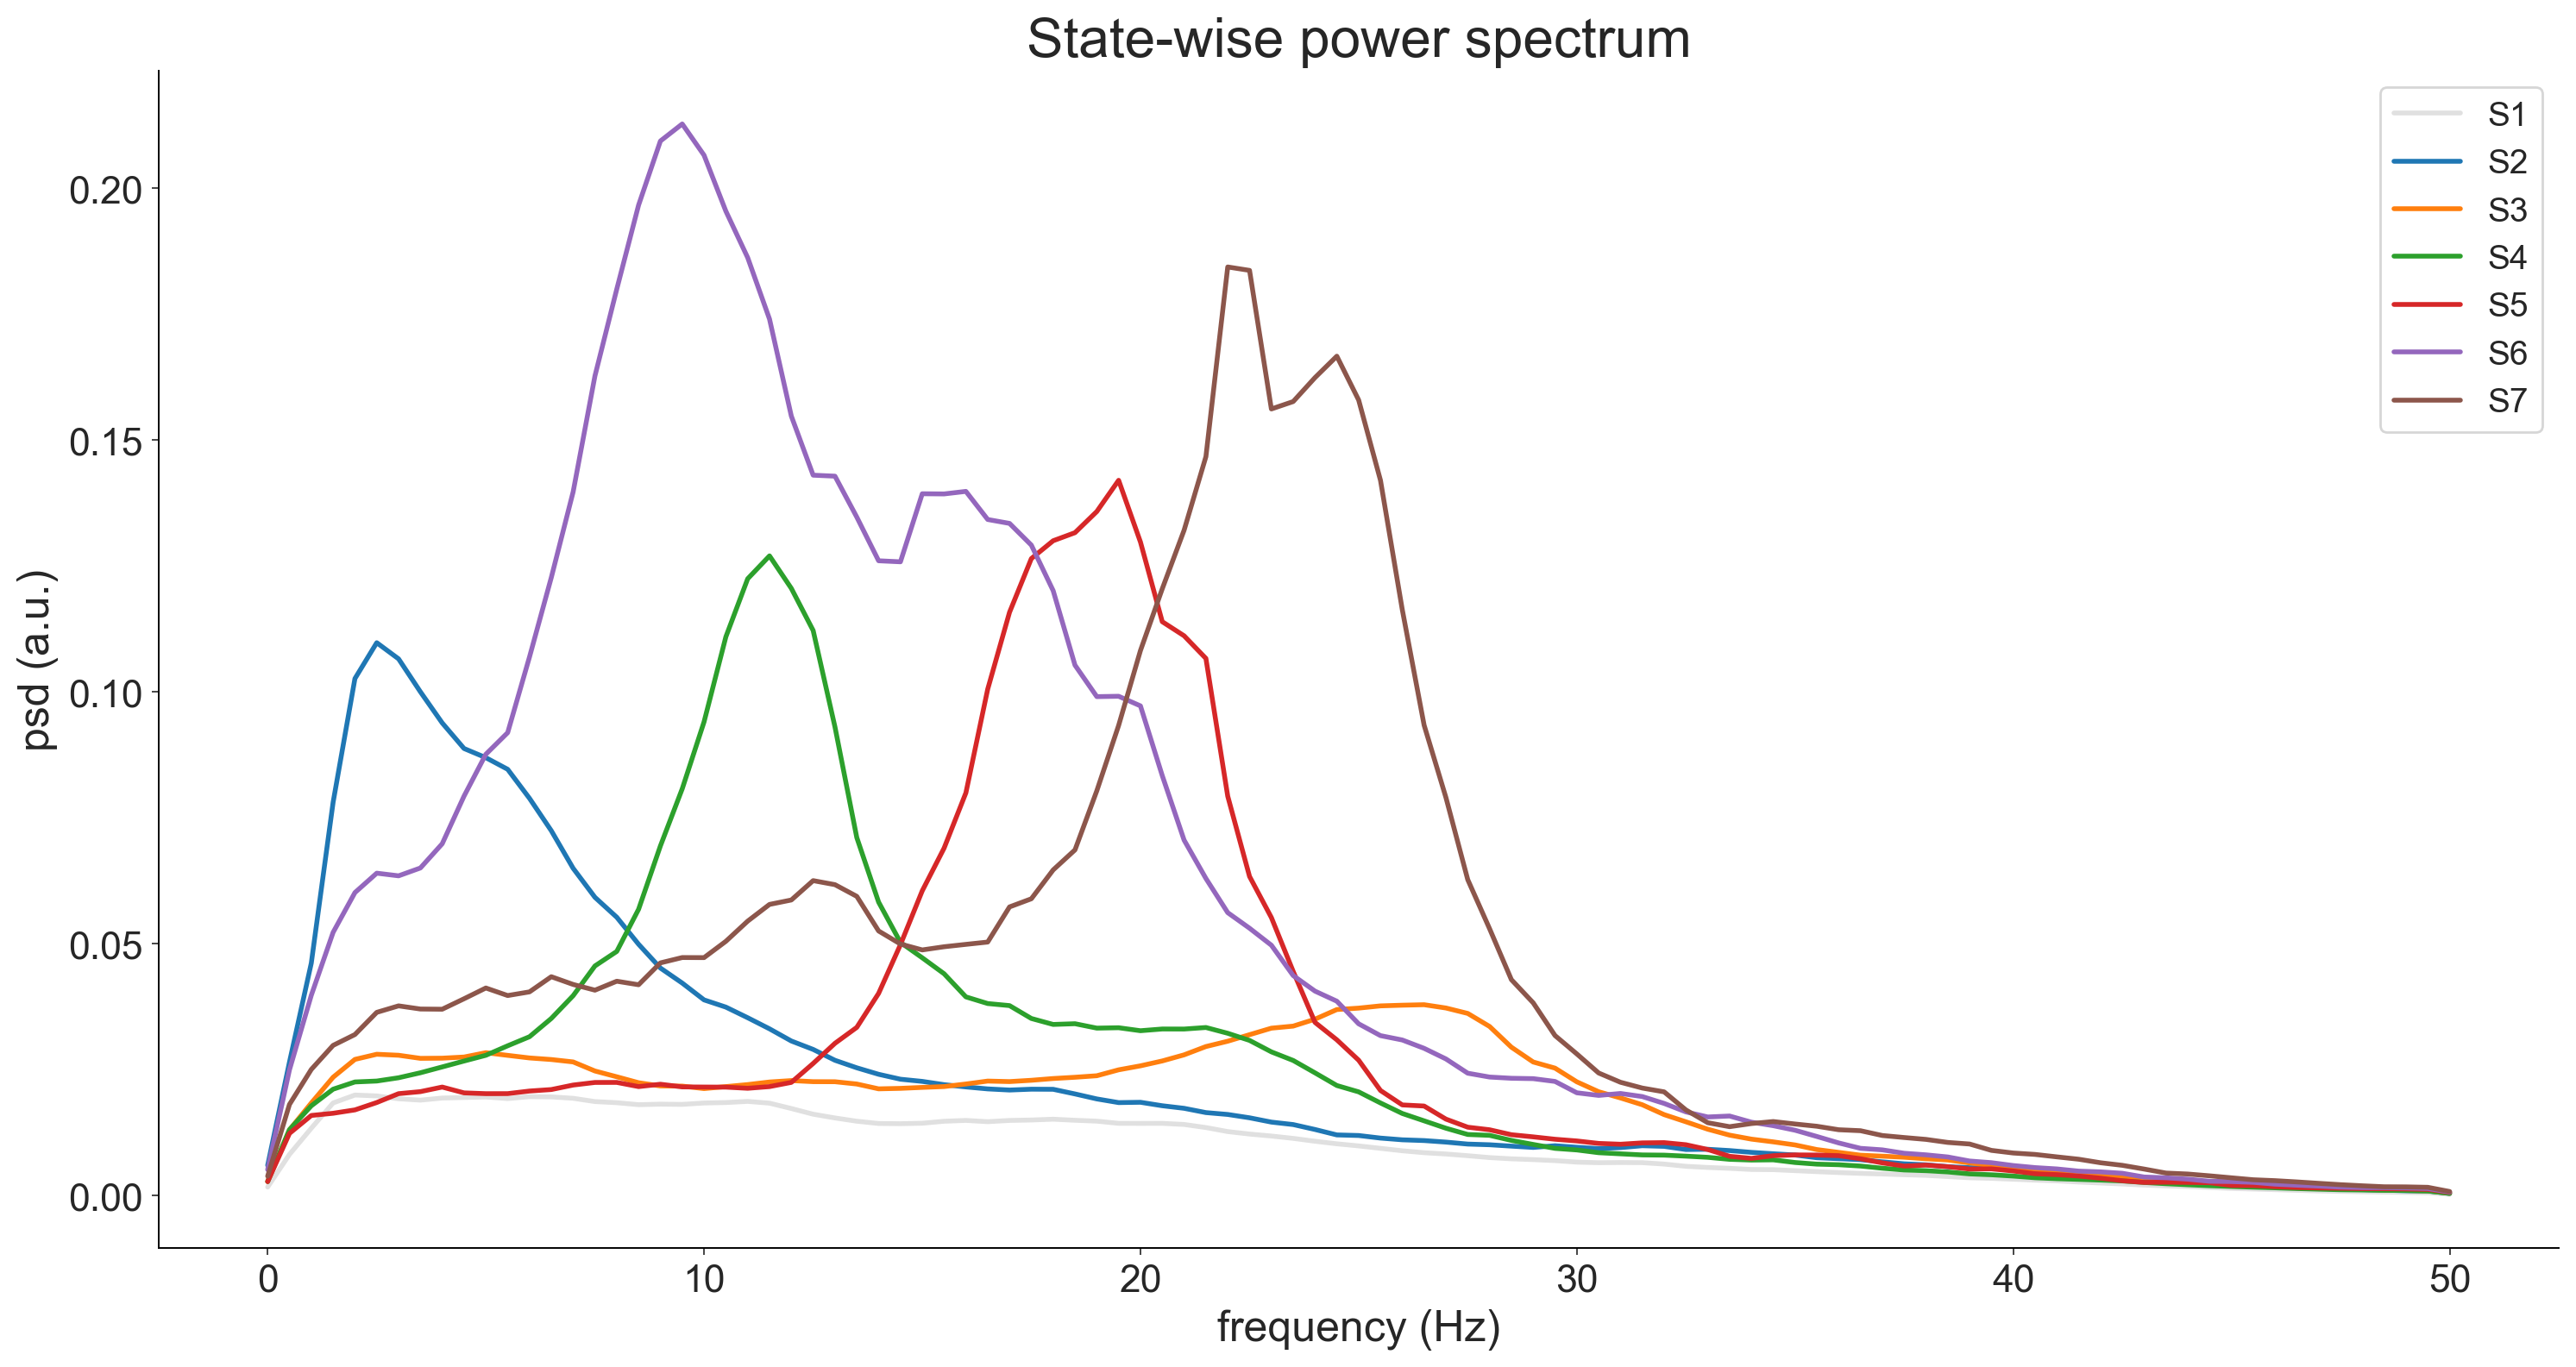

In [14]:
import matplotlib.pyplot as plt
from scipy.signal import welch

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(num_states)]
grey = ["#E0E0E0"]
colors = grey + colors
state_labels = [f"S{i+1}" for i in range(num_states)]


num_col = covs.shape[0]

plt.figure(figsize = (10, 6))#3B528B #22A884
for k, w in enumerate(weights):
    plt.bar(k,w, width = 0.9, color=colors[k], zorder = 3, align = "center", edgecolor = "black")
    plt.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center", fontsize = 15)
    #plt.xlim(-0.6, 2 * num_states - 0.4)
    plt.ylim(0.0, 0.7)
    plt.xticks(np.arange(num_states), labels = np.arange
               (1, num_states + 1), fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("State id", fontsize = 18)
    plt.ylabel("Mixture weight", fontsize = 18)
    plt.grid(True, alpha=0.5, axis = "y")

plt.title("TDE-DPGMM", fontsize = 25)



vmin  = np.min(covs)               # global minimum
vmax  = np.max(covs)               # global maximum
norm  = plt.Normalize(vmin, vmax)      # shared normalisation

fig, ax = plt.subplots(1, num_col, figsize = (num_col*4, 4))
for i ,cov in enumerate(covs):
    ax[i].imshow(cov, norm = norm, cmap = "viridis")
    ax[i].set_axis_off()


plt.figure(figsize = (15, 8))
for i in range(effective_num_states):
    if weights[i] < 0.001:
        continue
    mask = est_states == i
    plt.plot(f_vec[i], psd_vec[i], alpha = 1, linewidth = 2,color = colors[i], label = state_labels[i])
    plt.xlabel("frequency (Hz)", fontsize = 18)
    plt.ylabel("psd (a.u.)", fontsize = 18)
    plt.title("State-wise power spectrum", fontsize = 23)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize = 14, frameon = True)

In [15]:
for i in range(effective_num_states):
    peak_f = f_vec[i][np.argmax(psd_vec[i])]
    print(peak_f)

2.0
2.5
26.5
11.5
19.5
9.5
22.0


In [16]:

num_states


15

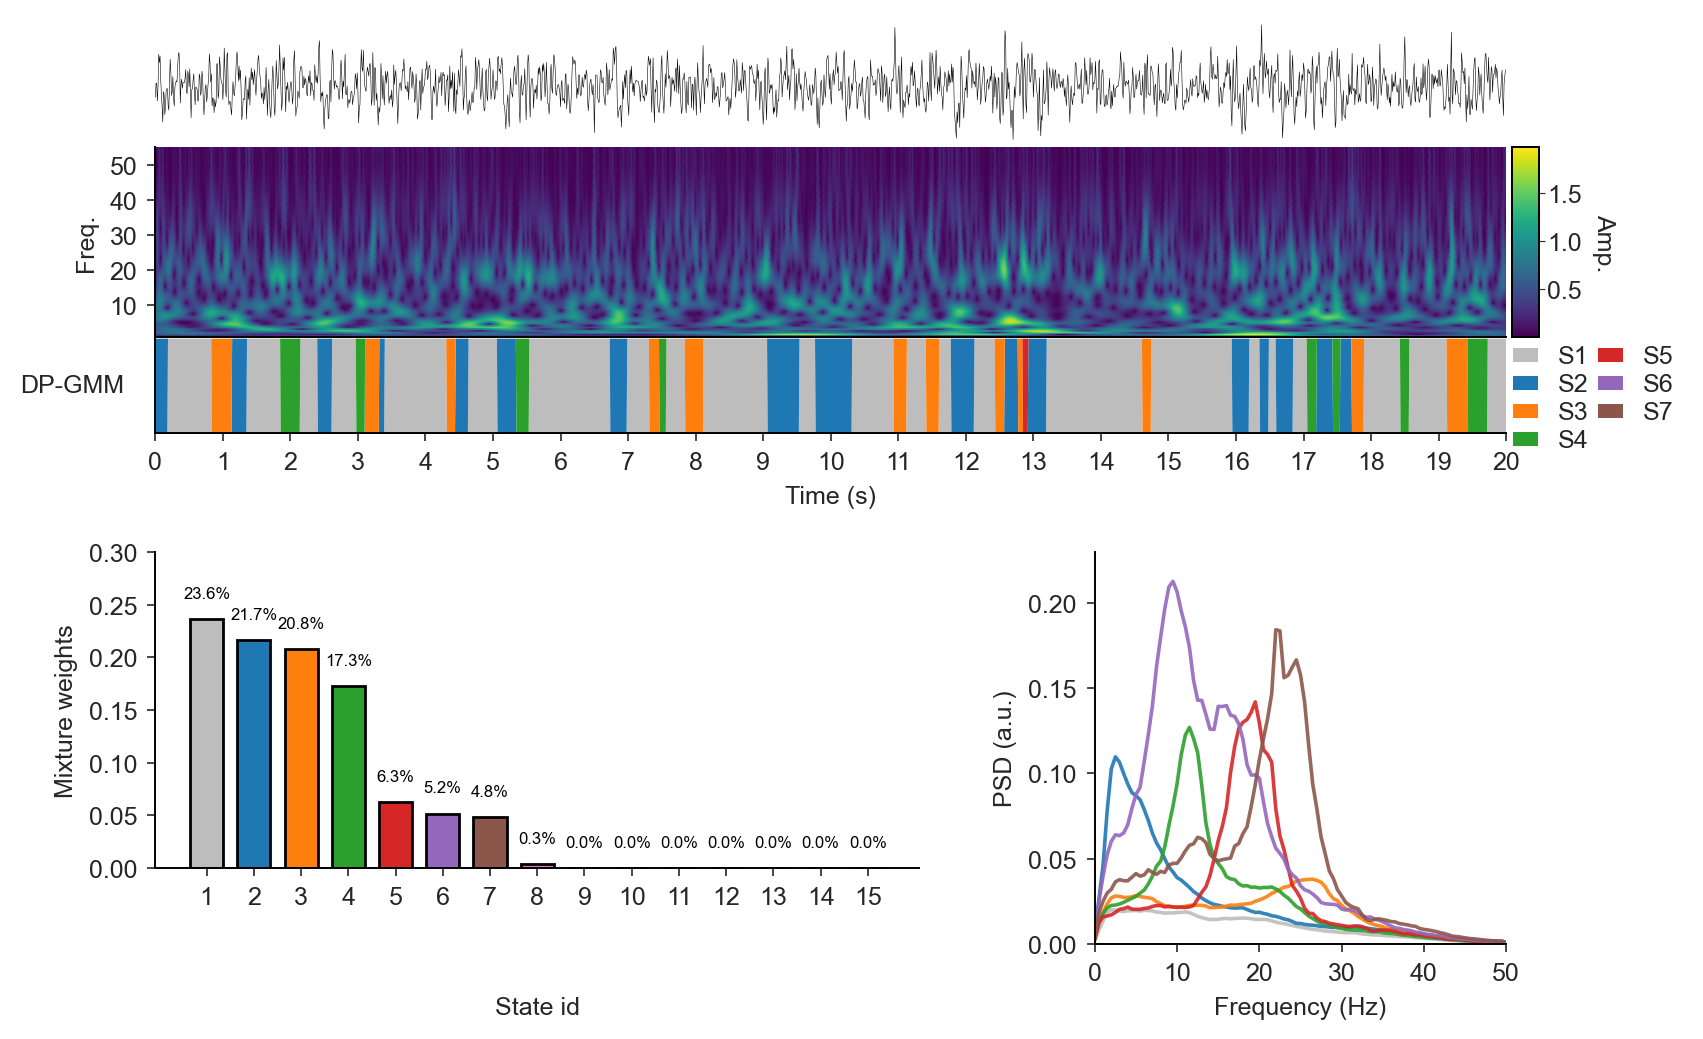

In [17]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(num_states+1)]
grey = ["#BDBDBD"]
colors = grey + colors


state_labels = [f"S{i+1}" for i in range(effective_num_states)]

start_t = 0
plot_t = 20



t, f, amp = compute_wavelet(trimmed_signal[start_t*fs:plot_t*fs], fs, f_min = 1, f_max = 80, df = 0.5, wavelet = "cmor1.5-1.0")
t += start_t

mosaic = [["a1", "a1"],
          ["a2", "a2"],
          ["a3", "a3"],
          ["gap", "gap"],
          ["b", "c"],
          ["d", "c"],
         ]

fig, axes = plt.subplot_mosaic(
    mosaic,
    figsize=(FIG_WIDTH, 5.),  # a hair taller
    constrained_layout=True,
    gridspec_kw={"height_ratios":[0.4,0.6,0.3, 0.1 ,1., 0.1],
                "width_ratios":[0.65,0.35]}
)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0., hspace=0.01)
axes["gap"].set_visible(False)


axes["a1"].plot(trimmed_time_vec[start_t*fs:plot_t*fs], trimmed_signal[start_t*fs:plot_t*fs], lw=0.2, color="k")
axes["a1"].set_frame_on(False)
#axes["a1"].set_title(f"Raw signal (SNR = {snr_db} dB)",pad= 0.3)
axes["a1"].sharex(axes["a3"])
axes["a1"].set_yticks([])
axes["a1"].set_xticks([])





#axes["b1"].set_ylabel(f"{plot_f}Hz", fontsize = TINY_SIZE, rotation = 0, labelpad = 20)

for s in ("top","right","bottom","left"):
    axes["a1"].spines[s].set_visible(False)
axes["a1"].set_frame_on(False)
axes["a1"].tick_params(axis='both', which='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labelleft=False)





im = axes["a2"].imshow(
    amp, extent=[t[0], t[-1], f[0], f[-1]],
    origin="lower", aspect="auto", cmap="viridis",
    vmin=amp.min(), vmax=amp.max()
)
axes["a2"].set_ylabel("Freq.")
#axes["a2"].set_title("Wavelet Transform",pad = 0.3)


axes["a2"].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
axes["a2"].yaxis.set_major_locator(MultipleLocator(10))

axes["a2"].set_ylim(1, 55)
#axes["a2"].sharex(axes["a1"])


cax = inset_axes(
    axes["a2"],              # parent axis
    width="2%",              # width as percentage of a2
    height="100%",           # match the height
    loc="center right",      # position inside a2
    borderpad=-1.3             # negative value moves it outside slightly
)

# Add the colorbar to the inset axis
cb = fig.colorbar(im, cax=cax)
cb.set_label("Amp.", rotation = 270, labelpad = 12)
cb.ax.tick_params(which="both", length=2, width=0.4, pad=1)



axes["a3"].stackplot(trimmed_time_vec[start_t*fs:plot_t*fs], est_states_onehot[start_t*fs:plot_t*fs].T, linewidth = 0, colors = colors, labels = state_labels)
axes["a3"].set_ylabel(f"DP-GMM", rotation = 0, labelpad=30, va="center")
#axes["a3"].sharex(axes["a4"])


for key in ["a1", "a2"]:
    axes[key].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

from matplotlib.ticker import MultipleLocator
axes["a3"].xaxis.set_major_locator(MultipleLocator(1.0))





    
axes["a3"].set_xlabel("Time (s)")

#axes["a4"].xaxis.set_major_locator(MultipleLocator(1.0))
#axes["a5"].xaxis.set_minor_locator(MultipleLocator(0.5))
#axes["a5"].tick_params(axis='x', which='both', bottom=True, labelbottom=True, length = 0)
axes["a3"].tick_params(axis='y', which='both', left=False, labelleft=False)
axes["a3"].set_ylim(0, 1)
axes["a3"].set_xlim(start_t, plot_t)


axes["a3"].spines["bottom"].set_visible(True)   # keep x-axis frame




handles, labels = axes["a3"].get_legend_handles_labels()

fig.legend(handles, labels,
           loc="center left",          # anchor to left of the bbox
           bbox_to_anchor=(0.98, 0.62), # (x, y) in figure coordinates
           frameon=False,
           handlelength=1,
           handleheight=0.5,
           labelspacing = 0.2,
           ncol = 2,
           columnspacing = 0.4,
           )





for k, w in enumerate(untrunc_weights):
    axes["b"].bar(k, w, width = 0.7, color = colors[k], zorder = 1, align = "center", edgecolor = "k")
    axes["b"].text(k, w + 0.02,"%.1f%%" % (w * 100.0), horizontalalignment="center", color = "k" , fontsize = MY_FONT_SIZE - 3 )
    axes["b"].set_ylabel("Mixture weights")
    axes["b"].set_xticks(np.arange(num_states), labels = np.arange(1, num_states + 1))
    axes["b"].tick_params(axis='y')


    axes["b"].set_ylim(0, 0.3)




for i in range(effective_num_states):

    axes["c"].plot(f_vec[i], psd_vec[i], color = colors[i], lw = 1.3, alpha = 0.9)
    axes["c"].set_xlim(0, 50)
    axes["c"].set_xlabel("Frequency (Hz)")
    axes["c"].set_ylabel("PSD (a.u.)")
    axes["c"].set_ylim(0, 0.23)
    #ab_c.tick_params(axis="both", which="both", bottom = False, top = False, left = False, right = False)
    #ab_c.grid(False)




axes["d"].set_xticks([])
axes["d"].set_yticks([])
axes["d"].spines[:].set_visible(False)
axes["d"].set_xlabel("State id")
fig.align_xlabels([axes["c"], axes["d"]])





#fig.align_ylabels([axes["a3"], axes["a4"]])



fig.canvas.draw()

fig.savefig(
    f"../figures/CTF_rest.jpg",
    bbox_inches="tight",)


plt.show()





/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_92255/266000322.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


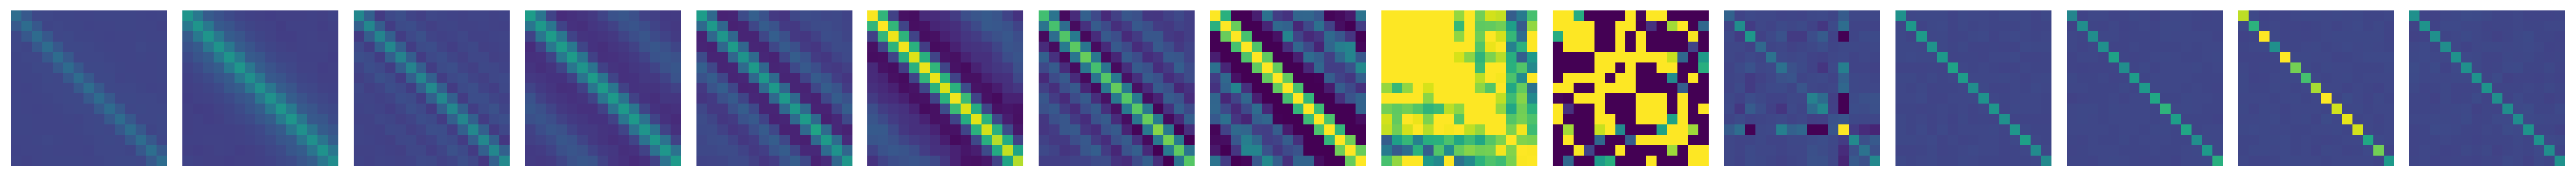

In [18]:
# shared normalisation
fig, ax = plt.subplots(1, untrunc_covs.shape[0], figsize = (untrunc_covs.shape[0]*2, 2), gridspec_kw = {"wspace":0.1})
for i ,cov in enumerate(untrunc_covs):
    ax[i].imshow(cov, norm = norm, cmap = "viridis")
    ax[i].set_axis_off()
    
fig.savefig(
    f"../figures/CTF_rest_covs.jpg",
    bbox_inches="tight")

In [19]:
subj_epoch_len = np.array([len(data_all[i]) for i in range(len(data_all))]) #track the subj_epoch for later
print(subj_epoch_len.sum())

subj_epoch_len[[0, -1]] -= num_emb//2 #trimmed the first and the last data points due to TDE
print(subj_epoch_len.sum())

subj_epoch = np.cumsum(subj_epoch_len)[:-1] #shape (num_subjects - 1)



states_sample = np.split(est_states, subj_epoch) #list of num_states array
trimmed_signal_sample = np.split(trimmed_signal, subj_epoch)



states_sample_onehot = [np.eye(effective_num_states)[states] for states in states_sample]
fo_sample = np.array([np.mean(states_onehot, axis = 0) for states_onehot in states_sample_onehot])
fo_sample.shape

1929832
1929818


(65, 7)

In [20]:
fo_sample

array([[5.08556459e-01, 2.80066683e-01, 7.85901405e-02, 7.91004661e-02,
        2.01748716e-02, 2.39853026e-02, 9.52607764e-03],
       [1.71065292e-01, 6.43161512e-01, 1.17972509e-01, 6.07560137e-02,
        0.00000000e+00, 7.04467354e-03, 0.00000000e+00],
       [1.85049505e-01, 1.29141914e-01, 2.67392739e-01, 1.08481848e-01,
        1.42244224e-02, 7.56105611e-02, 2.20099010e-01],
       [2.36700000e-01, 4.61500000e-01, 1.02433333e-01, 1.61866667e-01,
        6.46666667e-03, 2.87000000e-02, 2.33333333e-03],
       [3.97023411e-01, 4.02675585e-02, 2.64046823e-01, 9.21404682e-02,
        1.23578595e-01, 6.32441472e-02, 1.96989967e-02],
       [4.06711864e-01, 5.78644068e-02, 4.06542373e-01, 6.30508475e-03,
        1.30847458e-02, 8.71186441e-03, 1.00779661e-01],
       [5.91813606e-01, 7.13309556e-03, 2.00293324e-01, 7.90306990e-02,
        9.94300190e-02, 9.79967334e-03, 1.24995833e-02],
       [2.54208754e-01, 1.81750842e-01, 8.80134680e-02, 2.97676768e-01,
        4.93265993e-02, 1

In [21]:
fo_sample.shape

(65, 7)

In [22]:
import numpy as np

eps = 1e-6          # define "absent" as FO <= eps
present_thr = 1e-6  # optional: define "present" as FO >= 1%

for i in range(effective_num_states):
    x = fo_sample[:, i]

    n_absent = np.sum(x <= eps)
    n_present = np.sum(x >= present_thr)

    q25, q50, q75 = np.percentile(x, [25, 50, 75])
    iqr = q75 - q25

    print(
        f"S{i+1}: absent={n_absent}/{len(x)} "
        f"present(>= {present_thr:g})={n_present}/{len(x)} | "
        f"median={q50:.3f} [IQR {q25:.3f}, {q75:.3f}]"
    )


S1: absent=0/65 present(>= 1e-06)=65/65 | median=0.371 [IQR 0.230, 0.517]
S2: absent=0/65 present(>= 1e-06)=65/65 | median=0.173 [IQR 0.098, 0.280]
S3: absent=0/65 present(>= 1e-06)=65/65 | median=0.188 [IQR 0.093, 0.272]
S4: absent=0/65 present(>= 1e-06)=65/65 | median=0.101 [IQR 0.067, 0.162]
S5: absent=3/65 present(>= 1e-06)=62/65 | median=0.009 [IQR 0.003, 0.028]
S6: absent=1/65 present(>= 1e-06)=64/65 | median=0.030 [IQR 0.013, 0.054]
S7: absent=12/65 present(>= 1e-06)=53/65 | median=0.010 [IQR 0.001, 0.031]


/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1886598633.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


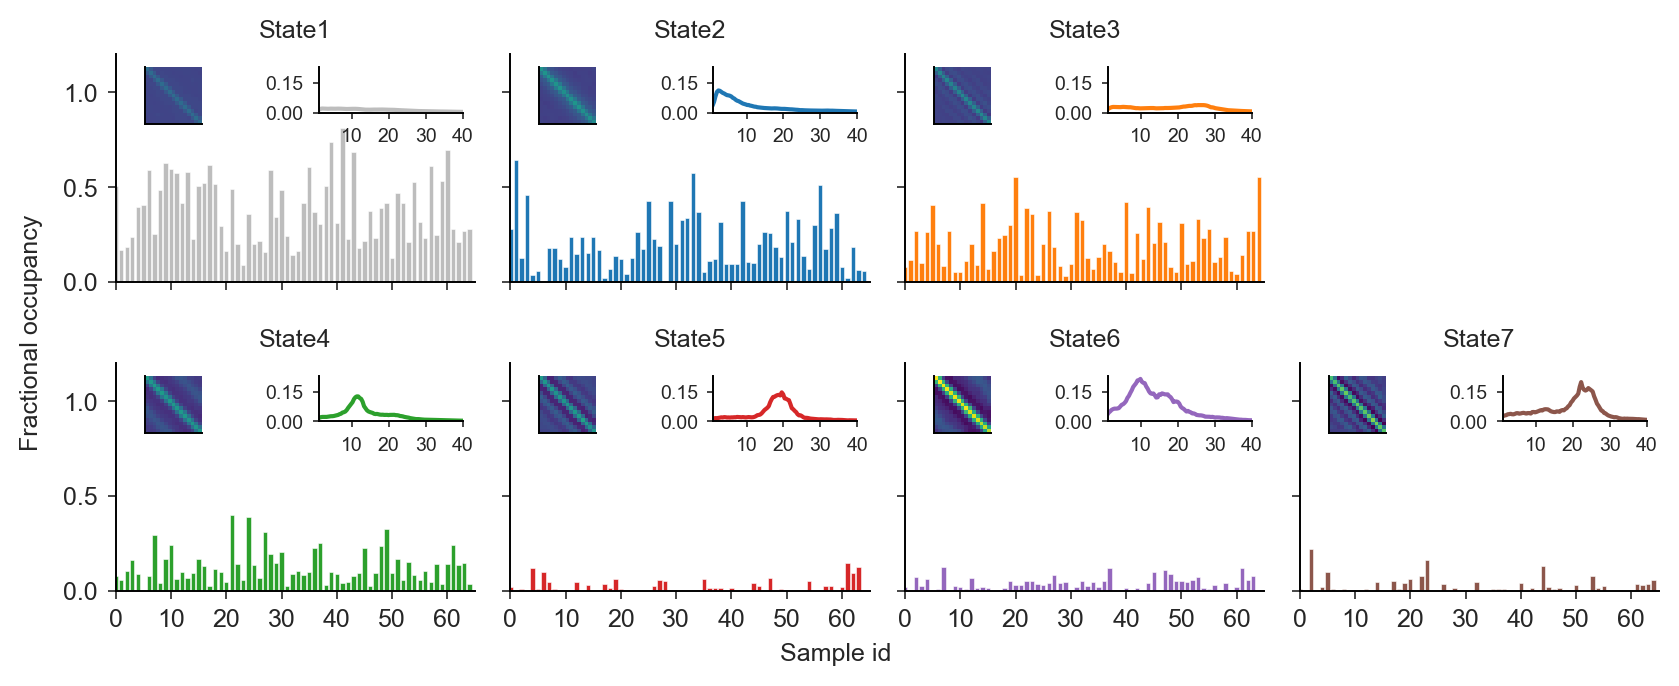

In [280]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(2, 4, figsize=(FIG_WIDTH+1, 3.4), sharex=True, sharey=True)

# Hide the unused slot (top-right). All remaining panels have identical size.
axes[0, 3].axis("off")

# Build a flat list of the 7 axes you will actually draw into:
axes_list = [
    axes[0, 0], axes[0, 1], axes[0, 2],      # 3 panels (row 1)
    axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3]  # 4 panels (row 2)
]

x = np.arange(fo_sample.shape[0])
state_labels = [f"State{i+1}" for i in range(effective_num_states)]

state_ids = np.where(fo > 0)[0]  # the 7 states you're plotting (assumed)

for i, sub_state_id in enumerate(state_ids):
    ax_i = axes_list[i]

    ax_i.bar(x, fo_sample[:, sub_state_id],
             color=colors[sub_state_id], width=0.8, alpha=1, linewidth=0.2)
    ax_i.set_title(state_labels[sub_state_id])
    ax_i.set_ylim(0, 1.2)
    ax_i.set_xlim(0, fo_sample.shape[0])
    ax_i.xaxis.set_major_locator(MaxNLocator(8))

    mask = est_states == sub_state_id
    f, psd = welch(trimmed_signal[mask], fs=fs)

    inset_i = inset_axes(ax_i, width="40%", height="20%", loc="upper right")
    inset_i.plot(f, psd, color=colors[sub_state_id], lw=1.5)
    inset_i.set_ylim(0, 0.23)
    inset_i.set_xlim(1, 40)
    inset_i.tick_params(axis='both', which='both', labelsize=MY_FONT_SIZE-2, length=2)
    inset_i.xaxis.set_major_locator(MaxNLocator(4))
    inset_i.yaxis.set_major_locator(MaxNLocator(2))

    inset_i_cov = inset_axes(ax_i, width="25%", height="25%", loc="upper left")
    vmin, vmax = np.min(covs), np.max(covs)
    norm = plt.Normalize(vmin, vmax)

    if sub_state_id == 10:
        inset_i_cov.remove()
    else:
        inset_i_cov.imshow(covs[sub_state_id], cmap="viridis", norm=norm)
        inset_i_cov.set_xticks([])
        inset_i_cov.set_yticks([])

fig.supxlabel("Participant", fontsize=MY_FONT_SIZE)
fig.supylabel("Fractional occupancy", fontsize=MY_FONT_SIZE)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

fig.savefig("../figures/CTF_rest_fo.jpg", bbox_inches="tight")


In [231]:
from nds_toolbox.analysis.burst_analysis import (state_fractional_occupancies, mean_state_lifetimes, CV_state_intervals, state_powers, state_burst_rates)

fo_sample = []
mean_lt_sample = []
cv_int_sample = []
powers_sample = []
burst_rates_sample = []

for i in range(len(states_sample)):
    states = states_sample[i]
    signal = trimmed_signal_sample[i]
    fo_states = state_fractional_occupancies(states, num_states = effective_num_states)
    mean_lt_states = mean_state_lifetimes(states, fs = fs, num_states = effective_num_states)
    cv_intervals = CV_state_intervals(states, fs = fs, num_states = effective_num_states)
    burst_rates = state_burst_rates(states, num_states = effective_num_states, fs = fs)



    powers = np.zeros(effective_num_states)
    for j in range(effective_num_states):

        mask = states == j

        x = signal[mask]
        x0 = x - np.mean(x) #remove DC offset
        powers[j] = np.var(x0)




    fo_sample.append(fo_states)
    mean_lt_sample.append(mean_lt_states)
    cv_int_sample.append(cv_intervals)
    powers_sample.append(powers)
    burst_rates_sample.append(burst_rates)


fo_sample = np.array(fo_sample)
mean_lt_sample = np.array(mean_lt_sample)
cv_int_sample = np.array(cv_int_sample)
powers_sample = np.array(powers_sample)
burst_rates_sample = np.array(burst_rates_sample)







/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yamadashoto/Library/Mobile Documents/com~apple~CloudDocs/PhD German/project/TDE-DP-GMM/nds_toolbox/analysis/burst_analysis.py:198: RuntimeWarning: Mean of empty slice
  return np.array([np.nanstd(intervals) / np.nanmean(intervals) for intervals in intervals_states])
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._va

In [292]:

rows = []
for idx in range(len(fo_sample)):
    for state in range(effective_num_states):
        rows.append({
            "sample_id": idx,
            "State id": state + 1,
            "fractional_occupancy": fo_sample[idx][state],
            "mean_lifetime": mean_lt_sample[idx][state],
            "cv_interval": cv_int_sample[idx][state],
            "power": powers_sample[idx][state],
            "burst_rate": burst_rates_sample[idx][state]
        })

df_long = pd.DataFrame(rows)

value_cols = ["fractional_occupancy","mean_lifetime","cv_interval","power","burst_rate"]
df_long[value_cols] = df_long[value_cols].replace(0, np.nan)


df_long

,sample_id,State id,fractional_occupancy,mean_lifetime,cv_interval,power,burst_rate
0,0,1,0.508556,0.417542,1.046488,0.506226,1.217977
1,0,2,0.280067,0.276242,0.995425,1.280246,1.013847
2,0,3,0.078590,0.199138,1.096044,0.911625,0.394652
3,0,4,0.079100,0.195378,1.103631,1.200742,0.404858
4,0,5,0.020175,0.197667,1.050990,1.503649,0.102065
...,...,...,...,...,...,...,...
450,64,3,0.553129,0.418939,0.875429,0.915325,1.320308
451,64,4,0.036242,0.194107,0.874324,1.261033,0.186710
452,64,5,0.004101,0.153750,0.531762,1.253754,0.026673
453,64,6,0.006935,0.189091,0.633262,2.610043,0.036675


/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1558818141.py:2: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x = "State id", y = "mean_lifetime", hue = "State id", palette = colors, ax = ax[0],linewidth = 0.8, legend = False)
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1558818141.py:5: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x = "State id", y = "power",  hue = "State id", palette = colors, ax = ax[1], linewidth = 0.8, legend = False)
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1558818141.py:8: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x = "State id", y = "burst_rate",  hue = "State id", palette = colors, ax = ax[2], linewidth = 0.8, legend = False)
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_

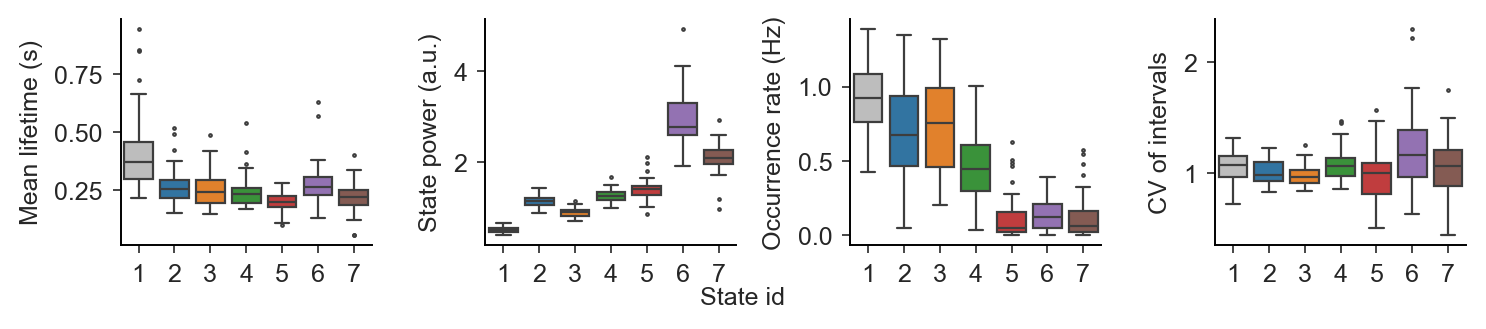

In [293]:
fig, ax = plt.subplots(1, 4, figsize = (FIG_WIDTH, 1.6))
sns.boxplot(df_long, x = "State id", y = "mean_lifetime", hue = "State id", palette = colors, ax = ax[0],linewidth = 0.8, legend = False)
ax[0].set_ylabel("Mean lifetime (s)")

sns.boxplot(df_long, x = "State id", y = "power",  hue = "State id", palette = colors, ax = ax[1], linewidth = 0.8, legend = False)
ax[1].set_ylabel("State power (a.u.)")

sns.boxplot(df_long, x = "State id", y = "burst_rate",  hue = "State id", palette = colors, ax = ax[2], linewidth = 0.8, legend = False)
ax[2].set_ylabel("Occurrence rate (Hz)")

sns.boxplot(df_long, x = "State id", y = "cv_interval",  hue = "State id", palette = colors, ax = ax[3], linewidth = 0.8, legend = False)
ax[3].set_ylabel("CV of intervals")

for a in ax:
    a.set_xlabel("")
fig.supxlabel("State id", fontsize = MY_FONT_SIZE)

plt.tight_layout()
plt.subplots_adjust(bottom=0.21) 

fig.savefig(
    f"../figures/CTF_rest_summary_stats.jpg",
    bbox_inches="tight")

In [294]:
summary_tidy

,,median,q1,q3
State id,metric,,,
1,burst_rate,0.921022,0.763672,1.082508
2,burst_rate,0.674474,0.463801,0.934028
3,burst_rate,0.754209,0.456939,0.990099
4,burst_rate,0.444064,0.300666,0.608088
5,burst_rate,0.047860,0.023262,0.153549
6,burst_rate,0.123398,0.046512,0.210176
7,burst_rate,0.059209,0.020408,0.164468
1,cv_interval,1.070002,0.968604,1.154703
2,cv_interval,0.985497,0.930440,1.095509


In [296]:
subset_states_ind = np.array([1, 2, 3, 4, 5, 6]) -1
subset_states_ind

array([0, 1, 2, 3, 4, 5])

                          median        q1        q3
State id metric                                     
1        burst_rate     0.921022  0.763672  1.082508
2        burst_rate     0.674474  0.463801  0.934028
3        burst_rate     0.754209  0.456939  0.990099
4        burst_rate     0.444064  0.300666  0.608088
5        burst_rate     0.047860  0.023262  0.153549
6        burst_rate     0.123398  0.046512  0.210176
7        burst_rate     0.059209  0.020408  0.164468
1        cv_interval    1.070002  0.968604  1.154703
2        cv_interval    0.985497  0.930440  1.095509
3        cv_interval    0.966220  0.913846  1.025375
4        cv_interval    1.067573  0.977444  1.138652
5        cv_interval    0.997344  0.814694  1.090445
6        cv_interval    1.163618  0.968309  1.387912
7        cv_interval    1.064499  0.887196  1.212316
1        mean_lifetime  0.369729  0.298922  0.458817
2        mean_lifetime  0.254161  0.217500  0.293333
3        mean_lifetime  0.244170  0.197956  0.

/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1269879162.py:41: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x="State id", y="mean_lifetime", hue="State id",
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1269879162.py:47: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x="State id", y="power", hue="State id",
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1269879162.py:53: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x="State id", y="burst_rate", hue="State id",
/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_2927/1269879162.py:59: UserWarning: The palette list has more values (17) than needed (7), which may not be intended.
  sns.boxplot(df_long, x="State id", y="cv_interval", hue="State id",


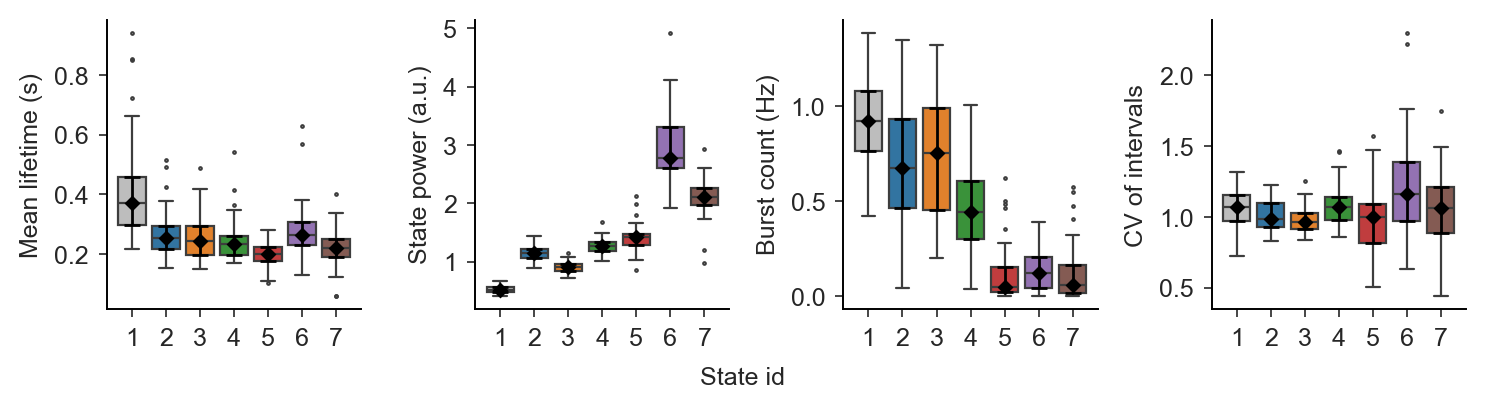

In [295]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["mean_lifetime", "power", "burst_rate", "cv_interval"]
state_order = sorted(df_long["State id"].unique())  # ensure consistent order

# ---------- 1) Median + IQR table ----------
summary_tidy = (
    df_long.melt(id_vars="State id", value_vars=metrics,
                 var_name="metric", value_name="value")
    .groupby(["State id", "metric"])["value"]
    .agg(median="median",
         q1=lambda s: s.quantile(0.25),
         q3=lambda s: s.quantile(0.75))
    .sort_values(["metric","State id"])
)

print(summary_tidy)


# (Optional) save
# summary_tidy.to_csv("../figures/CTF_rest_summary_stats_median_IQR.csv", index=False)


# ---------- 2) Overlay median + IQR on the boxplots ----------
def add_median_IQR(ax, df, metric, order):
    g = (df.groupby("State id")[metric]
           .agg(median="median",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75))
           .reindex(order))
    xs = np.arange(len(order))
    y = g["median"].to_numpy()
    yerr = np.vstack([y - g["q1"].to_numpy(), g["q3"].to_numpy() - y])
    ax.errorbar(xs, y, yerr=yerr, fmt="D", ms=3, lw=1, capsize=3, zorder=3, color="k")

fig, ax = plt.subplots(1, 4, figsize=(FIG_WIDTH, 2))

sns.boxplot(df_long, x="State id", y="mean_lifetime", hue="State id",
            order=state_order, hue_order=state_order,
            palette=colors, ax=ax[0], linewidth=0.8, legend=False)
ax[0].set_ylabel("Mean lifetime (s)")
add_median_IQR(ax[0], df_long, "mean_lifetime", state_order)

sns.boxplot(df_long, x="State id", y="power", hue="State id",
            order=state_order, hue_order=state_order,
            palette=colors, ax=ax[1], linewidth=0.8, legend=False)
ax[1].set_ylabel("State power (a.u.)")
add_median_IQR(ax[1], df_long, "power", state_order)

sns.boxplot(df_long, x="State id", y="burst_rate", hue="State id",
            order=state_order, hue_order=state_order,
            palette=colors, ax=ax[2], linewidth=0.8, legend=False)
ax[2].set_ylabel("Burst count (Hz)")
add_median_IQR(ax[2], df_long, "burst_rate", state_order)

sns.boxplot(df_long, x="State id", y="cv_interval", hue="State id",
            order=state_order, hue_order=state_order,
            palette=colors, ax=ax[3], linewidth=0.8, legend=False)
ax[3].set_ylabel("CV of intervals")
add_median_IQR(ax[3], df_long, "cv_interval", state_order)

for a in ax:
    a.set_xlabel("")
fig.supxlabel("State id", fontsize=MY_FONT_SIZE)

plt.tight_layout()
plt.subplots_adjust(bottom=0.21)


In [297]:
z = states_sample[ids[1]]
z_onehot = np.eye(effective_num_states)[z]
z_time_vec =  np.linspace(0, len(z)/fs, len(z))

NameError: name 'ids' is not defined

In [102]:
z_onehot.T

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]], shape=(7, 29800))

In [23]:
i = subset_states_ind[2]
ids = np.where(cv_int_sample[:,i] > 1.5)[0]
print(ids)
fo_sample[ids, i]*100

NameError: name 'subset_states_ind' is not defined

In [24]:
fo_sample.shape

(65, 7)

sample ID:  41
fo 0.8101099962070274


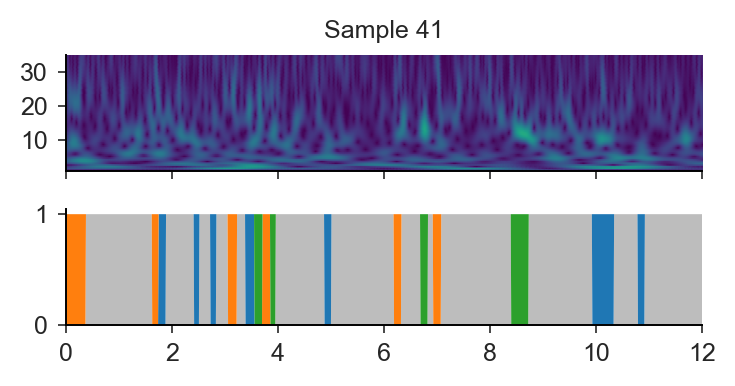

sample ID:  1
fo 0.6431615120274914


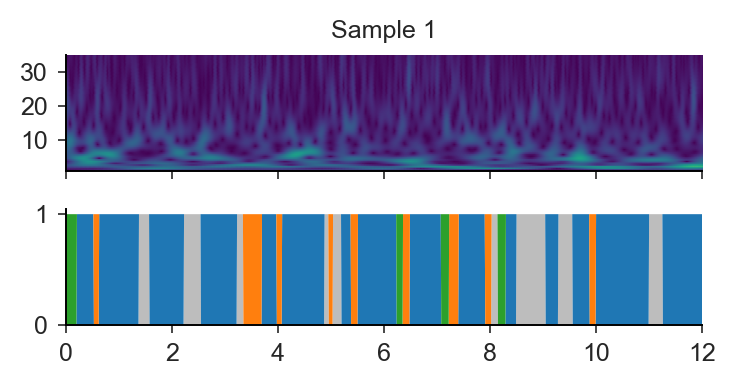

sample ID:  20
fo 0.5546710526315789


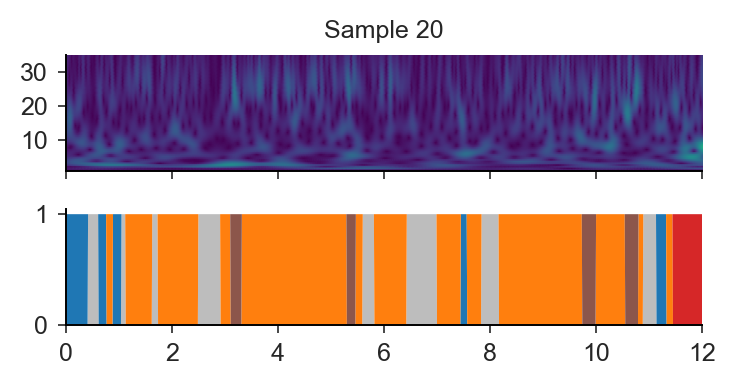

sample ID:  21
fo 0.39967809321598574


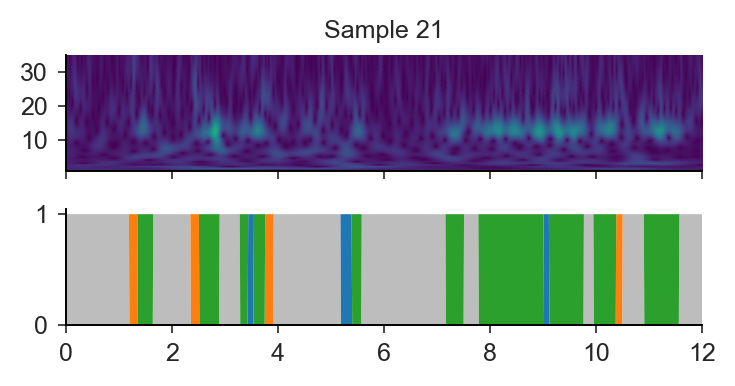

sample ID:  61
fo 0.14963815789473683


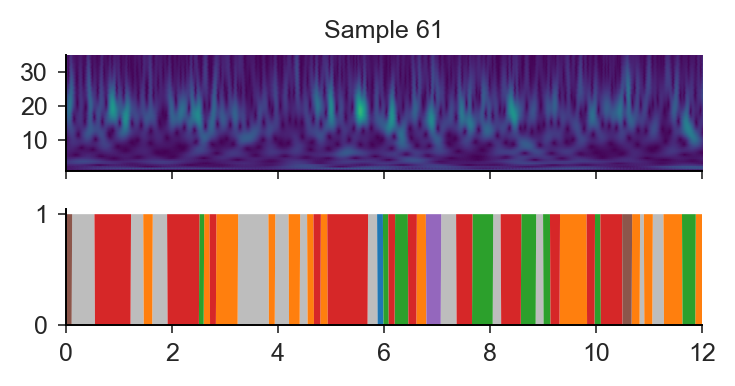

sample ID:  7
fo 0.1257239057239057


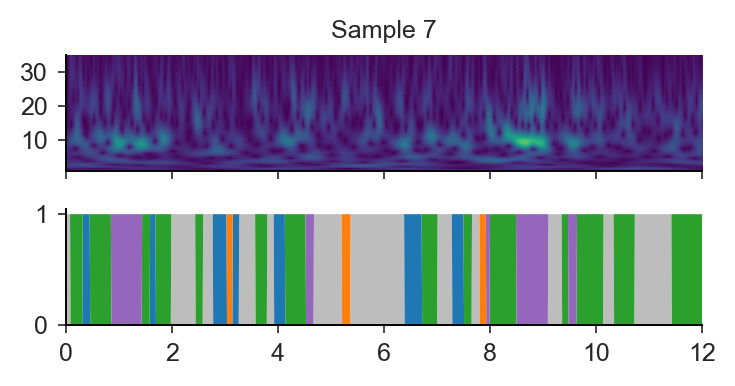

In [298]:
max_fo_ind = np.argmax(fo_sample, axis = 0)

for i in subset_states_ind:
    id = max_fo_ind[i]
    print("sample ID: ", id)
    print("fo", fo_sample[id, i])

    x = trimmed_signal_sample[id]
    z = states_sample[id]
    z_onehot = np.eye(effective_num_states)[z]
    z_time_vec =  np.linspace(0, len(z)/fs, len(z))




    fig, ax = plt.subplots(2, 1, figsize=(FIG_WIDTH/2, 2), sharex=True)
    t, f, amp = compute_wavelet(x, fs, f_min = 1, f_max = 80, df = 0.5, wavelet = "cmor1.5-1.0")
    ax[0].imshow(
        amp, extent=[t[0], t[-1], f[0], f[-1]],
        origin="lower", aspect="auto", cmap="viridis",
        vmin=amp.min(), vmax=amp.max()
    )
    ax[0].set_ylim(1, 35)
    ax[0].set_title(f"Sample {id}")

    ax[1].stackplot(z_time_vec, z_onehot.T, colors = colors, linewidth = 0)

    ax[1].set_xlim(0, 12)

    plt.show()

#np.array(trimmed_signal_sample, dtype = object)[mask]

<Axes: label='a1'>

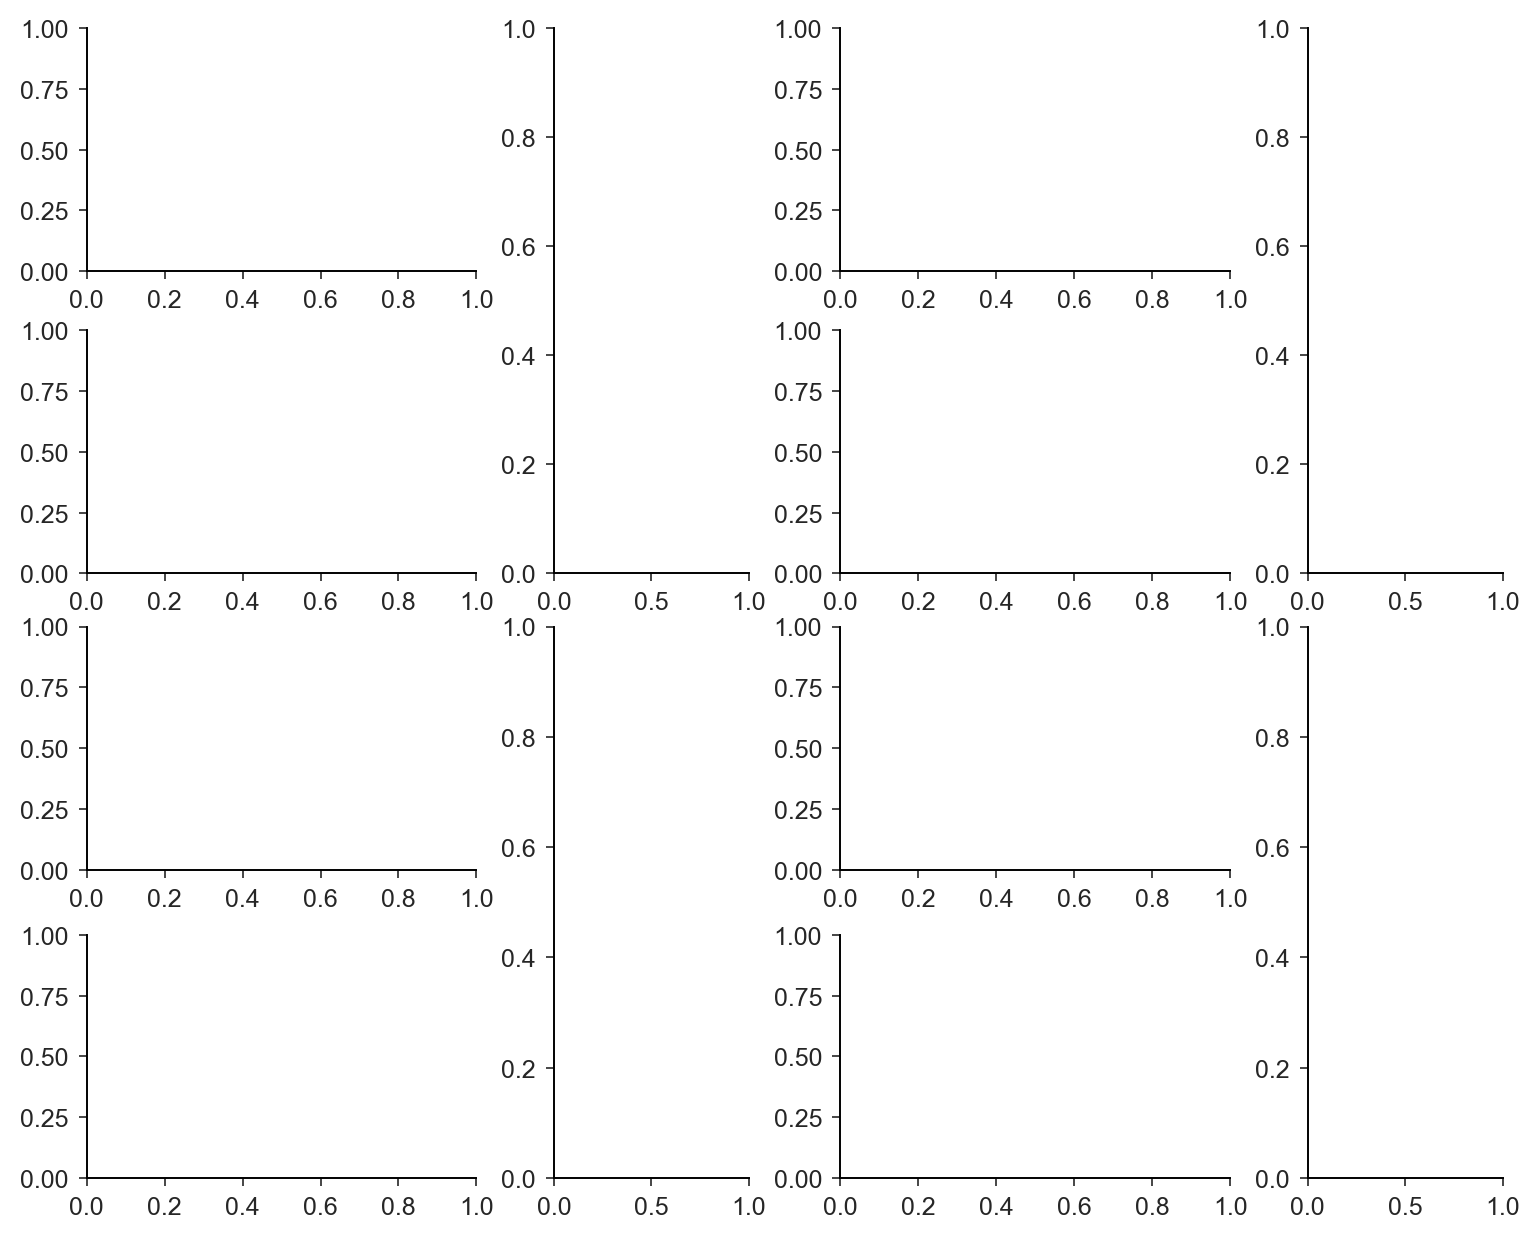

In [299]:


mosaic = [["a1", "a3", "b1", "b3"],
          ["a2", "a3", "b2", "b3"],
         ["c1", "c3", "d1", "d3"],
         ["c2", "c3", "d2", "d3"],]

fig, axes = plt.subplot_mosaic(
    mosaic,
    figsize=(FIG_WIDTH, 6.),  # a hair taller
    constrained_layout=True,
    gridspec_kw={"width_ratios": [1, 0.5, 1, 0.5]},
)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0., hspace=0.01)

axes["a1"]

In [27]:
fig, ax = plt.subplots(len(subset_states_ind),2 , figsize = (FIG_WIDTH, 4), sharex=True)
for i, sub_id in enumerate(subset_states_ind):

    #ax[i, 0].scatter(mean_lt_sample[:,sub_id], burst_rates_sample[:,sub_id] , color = colors[sub_id])
    ax[i, 1].hist(mean_lt_sample[:,sub_id], color = colors[sub_id], bins = 15)


ax[-1, 1].set_xlabel("CV2 of state intervals")
plt.show()

NameError: name 'subset_states_ind' is not defined

/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_18283/173897429.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(powers_sample[:,subset_states_ind[2]], fo_sample[:,subset_states_ind[2]], c = colors[subset_states_ind[0]])


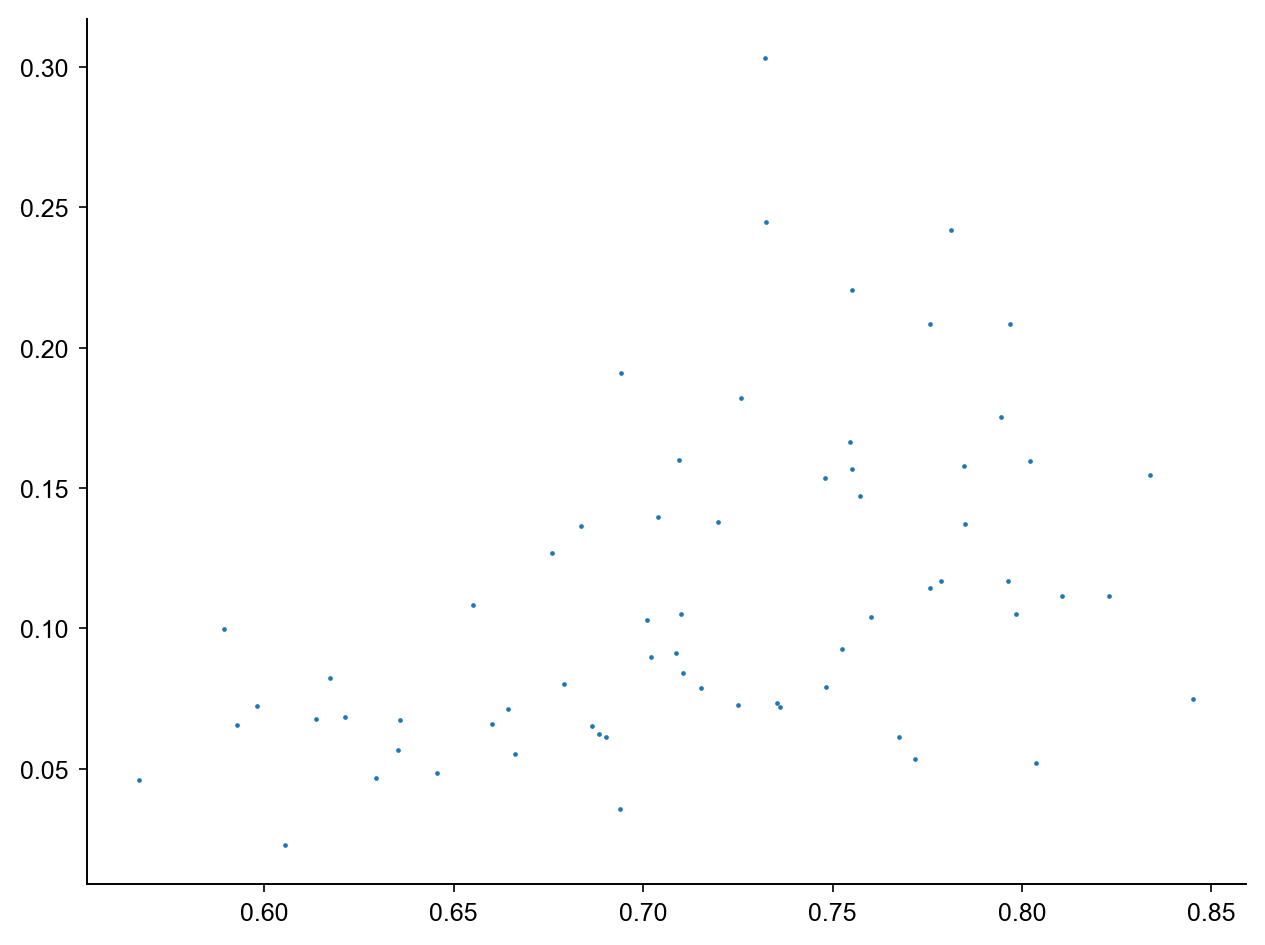

In [105]:
plt.scatter(powers_sample[:,subset_states_ind[2]], fo_sample[:,subset_states_ind[2]], c = colors[subset_states_ind[0]])

In [ ]:
mosaic = [["a1", "a1"],
          ["b2", "a2"],
          ["a3", "a3"],
          ["a4", "a4"],
          ["gap", "gap"],
          ["b", "c"],
          ["d", "e"],
         ]

fig, axes = plt.subplot_mosaic(
    mosaic,
    figsize=(FIG_WIDTH, 6.),  # a hair taller
    constrained_layout=True,
    gridspec_kw={"height_ratios":[0.4,0.6,0.3,0.3, 0.1 ,1.5, 0.3]}
)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0., hspace=0.01)